In [40]:
from transpile_benchy.interface import QASMBench

qasm_bench = QASMBench(size="medium")

from transpile_benchy.metrics import DepthMetric

depth_metric = DepthMetric()

from qiskit.transpiler import CouplingMap

coupling_map = CouplingMap.from_grid(5, 6)

from virtual_swap.pass_managers import SabreCNSV2, SabreQiskit

In [41]:
import logging
from transpile_benchy.benchmark import Benchmark

# Create a specific logger for transpile_benchy and set its level to DEBUG
transpile_benchy_logger = logging.getLogger("transpile_benchy")
# transpile_benchy_logger.setLevel(logging.DEBUG)
transpile_benchy_logger.setLevel(logging.INFO)

# Silence the qiskit logger by setting its level to WARNING or higher
qiskit_logger = logging.getLogger("qiskit")
qiskit_logger.setLevel(logging.WARNING)

benchmark = Benchmark(
    transpilers=[
        SabreCNSV2(coupling_map, logger=transpile_benchy_logger),
        SabreQiskit(coupling_map),
    ],
    submodules=[qasm_bench],
    metrics=[depth_metric],
    logger=transpile_benchy_logger,
    num_runs=10,
)
benchmark.run()

INFO:transpile_benchy:Running benchmarks for circuits...
Running circuits for QASMBench:   0%|          | 0/20 [00:00<?, ?it/s]INFO:transpile_benchy:Running benchmark for circuit multiplier_n15
INFO:transpile_benchy:Accepted CNS subs: 63
INFO:transpile_benchy:Accepted CNS subs: 81
INFO:transpile_benchy:Accepted CNS subs: 72
INFO:transpile_benchy:Accepted CNS subs: 87
INFO:transpile_benchy:Accepted CNS subs: 73
INFO:transpile_benchy:Accepted CNS subs: 75
INFO:transpile_benchy:Accepted CNS subs: 77
INFO:transpile_benchy:Accepted CNS subs: 76
INFO:transpile_benchy:Accepted CNS subs: 78
INFO:transpile_benchy:Accepted CNS subs: 73
Running circuits for QASMBench:   5%|▌         | 1/20 [00:11<03:34, 11.30s/it]INFO:transpile_benchy:Running benchmark for circuit wstate_n27
INFO:transpile_benchy:Accepted CNS subs: 4
INFO:transpile_benchy:Accepted CNS subs: 8
INFO:transpile_benchy:Accepted CNS subs: 4
INFO:transpile_benchy:Accepted CNS subs: 1
INFO:transpile_benchy:Accepted CNS subs: 4
INFO:trans

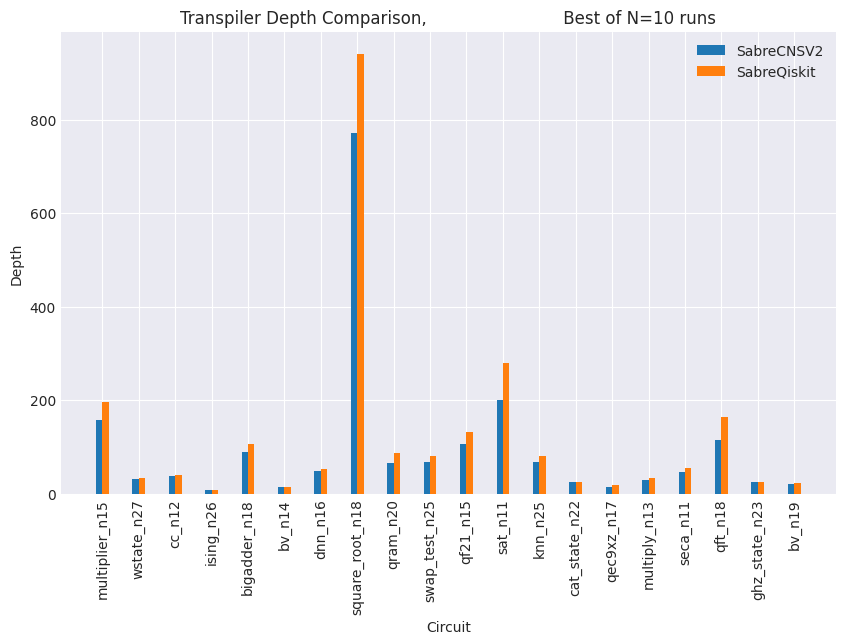

In [42]:
benchmark.plot()

In [47]:
benchmark.results

{'Depth': {'multiplier_n15': {'SabreCNSV2': 158, 'SabreQiskit': 196},
  'wstate_n27': {'SabreCNSV2': 32, 'SabreQiskit': 33},
  'cc_n12': {'SabreCNSV2': 38, 'SabreQiskit': 39},
  'ising_n26': {'SabreCNSV2': 9, 'SabreQiskit': 7},
  'bigadder_n18': {'SabreCNSV2': 89, 'SabreQiskit': 106},
  'bv_n14': {'SabreCNSV2': 14, 'SabreQiskit': 15},
  'dnn_n16': {'SabreCNSV2': 48, 'SabreQiskit': 53},
  'square_root_n18': {'SabreCNSV2': 771, 'SabreQiskit': 941},
  'qram_n20': {'SabreCNSV2': 66, 'SabreQiskit': 86},
  'swap_test_n25': {'SabreCNSV2': 68, 'SabreQiskit': 80},
  'qf21_n15': {'SabreCNSV2': 106, 'SabreQiskit': 133},
  'sat_n11': {'SabreCNSV2': 200, 'SabreQiskit': 280},
  'knn_n25': {'SabreCNSV2': 68, 'SabreQiskit': 81},
  'cat_state_n22': {'SabreCNSV2': 24, 'SabreQiskit': 26},
  'qec9xz_n17': {'SabreCNSV2': 15, 'SabreQiskit': 19},
  'multiply_n13': {'SabreCNSV2': 29, 'SabreQiskit': 33},
  'seca_n11': {'SabreCNSV2': 46, 'SabreQiskit': 54},
  'qft_n18': {'SabreCNSV2': 115, 'SabreQiskit': 164},


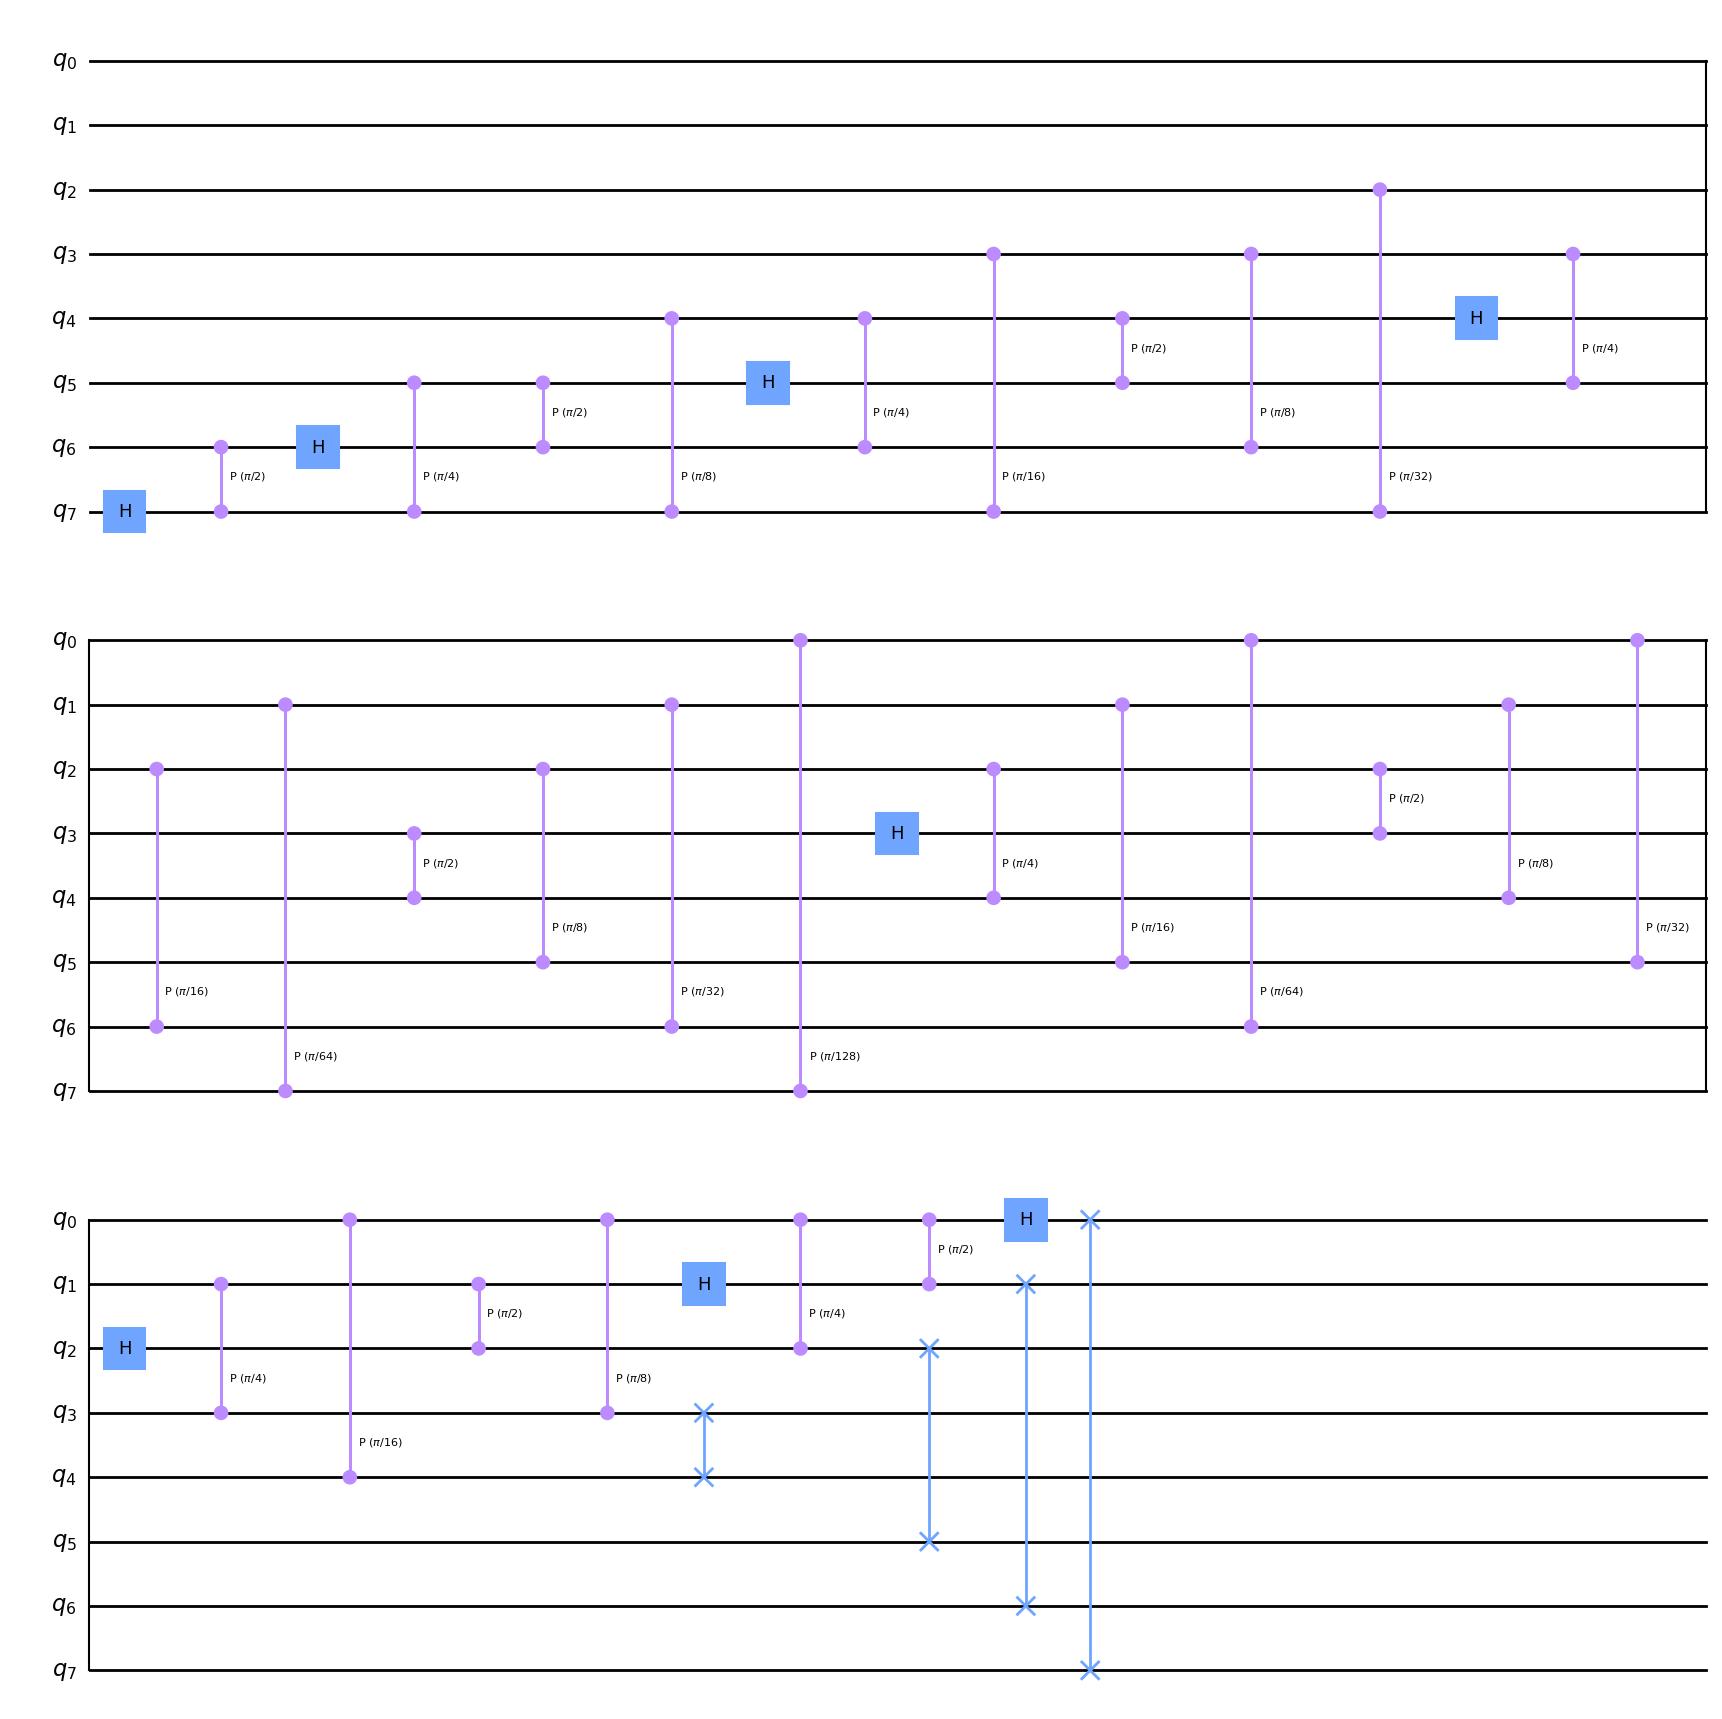

In [44]:
from qiskit.circuit.library import QFT

qc = QFT(8)
qc.decompose().draw(output="mpl")

48


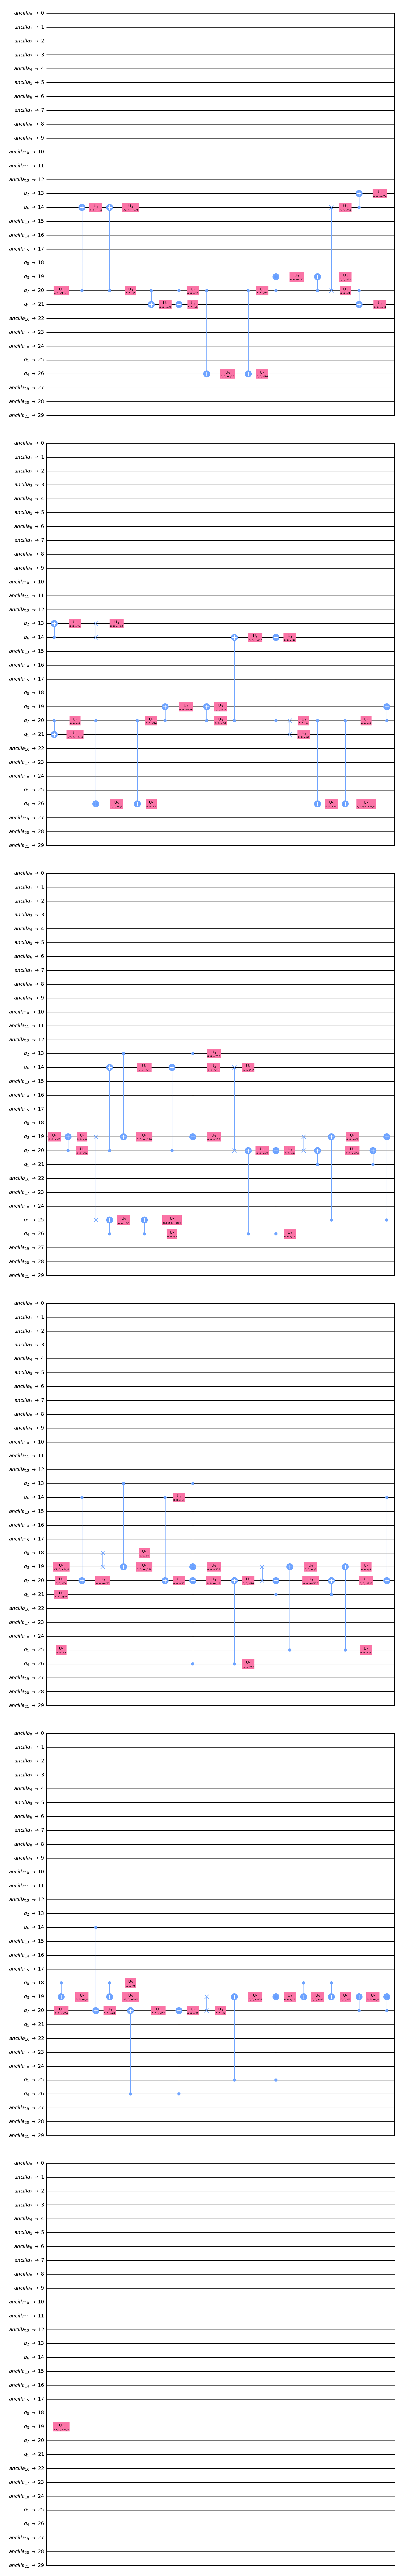

In [45]:
from qiskit import transpile

transp = transpile(
    qc,
    coupling_map=coupling_map,
    basis_gates=["cx", "u3", "swap"],
    optimization_level=3,
)
from transpile_benchy.metrics import DepthMetric

print(DepthMetric.calculate(transp))
transp.draw("mpl")

INFO:transpile_benchy:Accepted CNS subs: 15


38


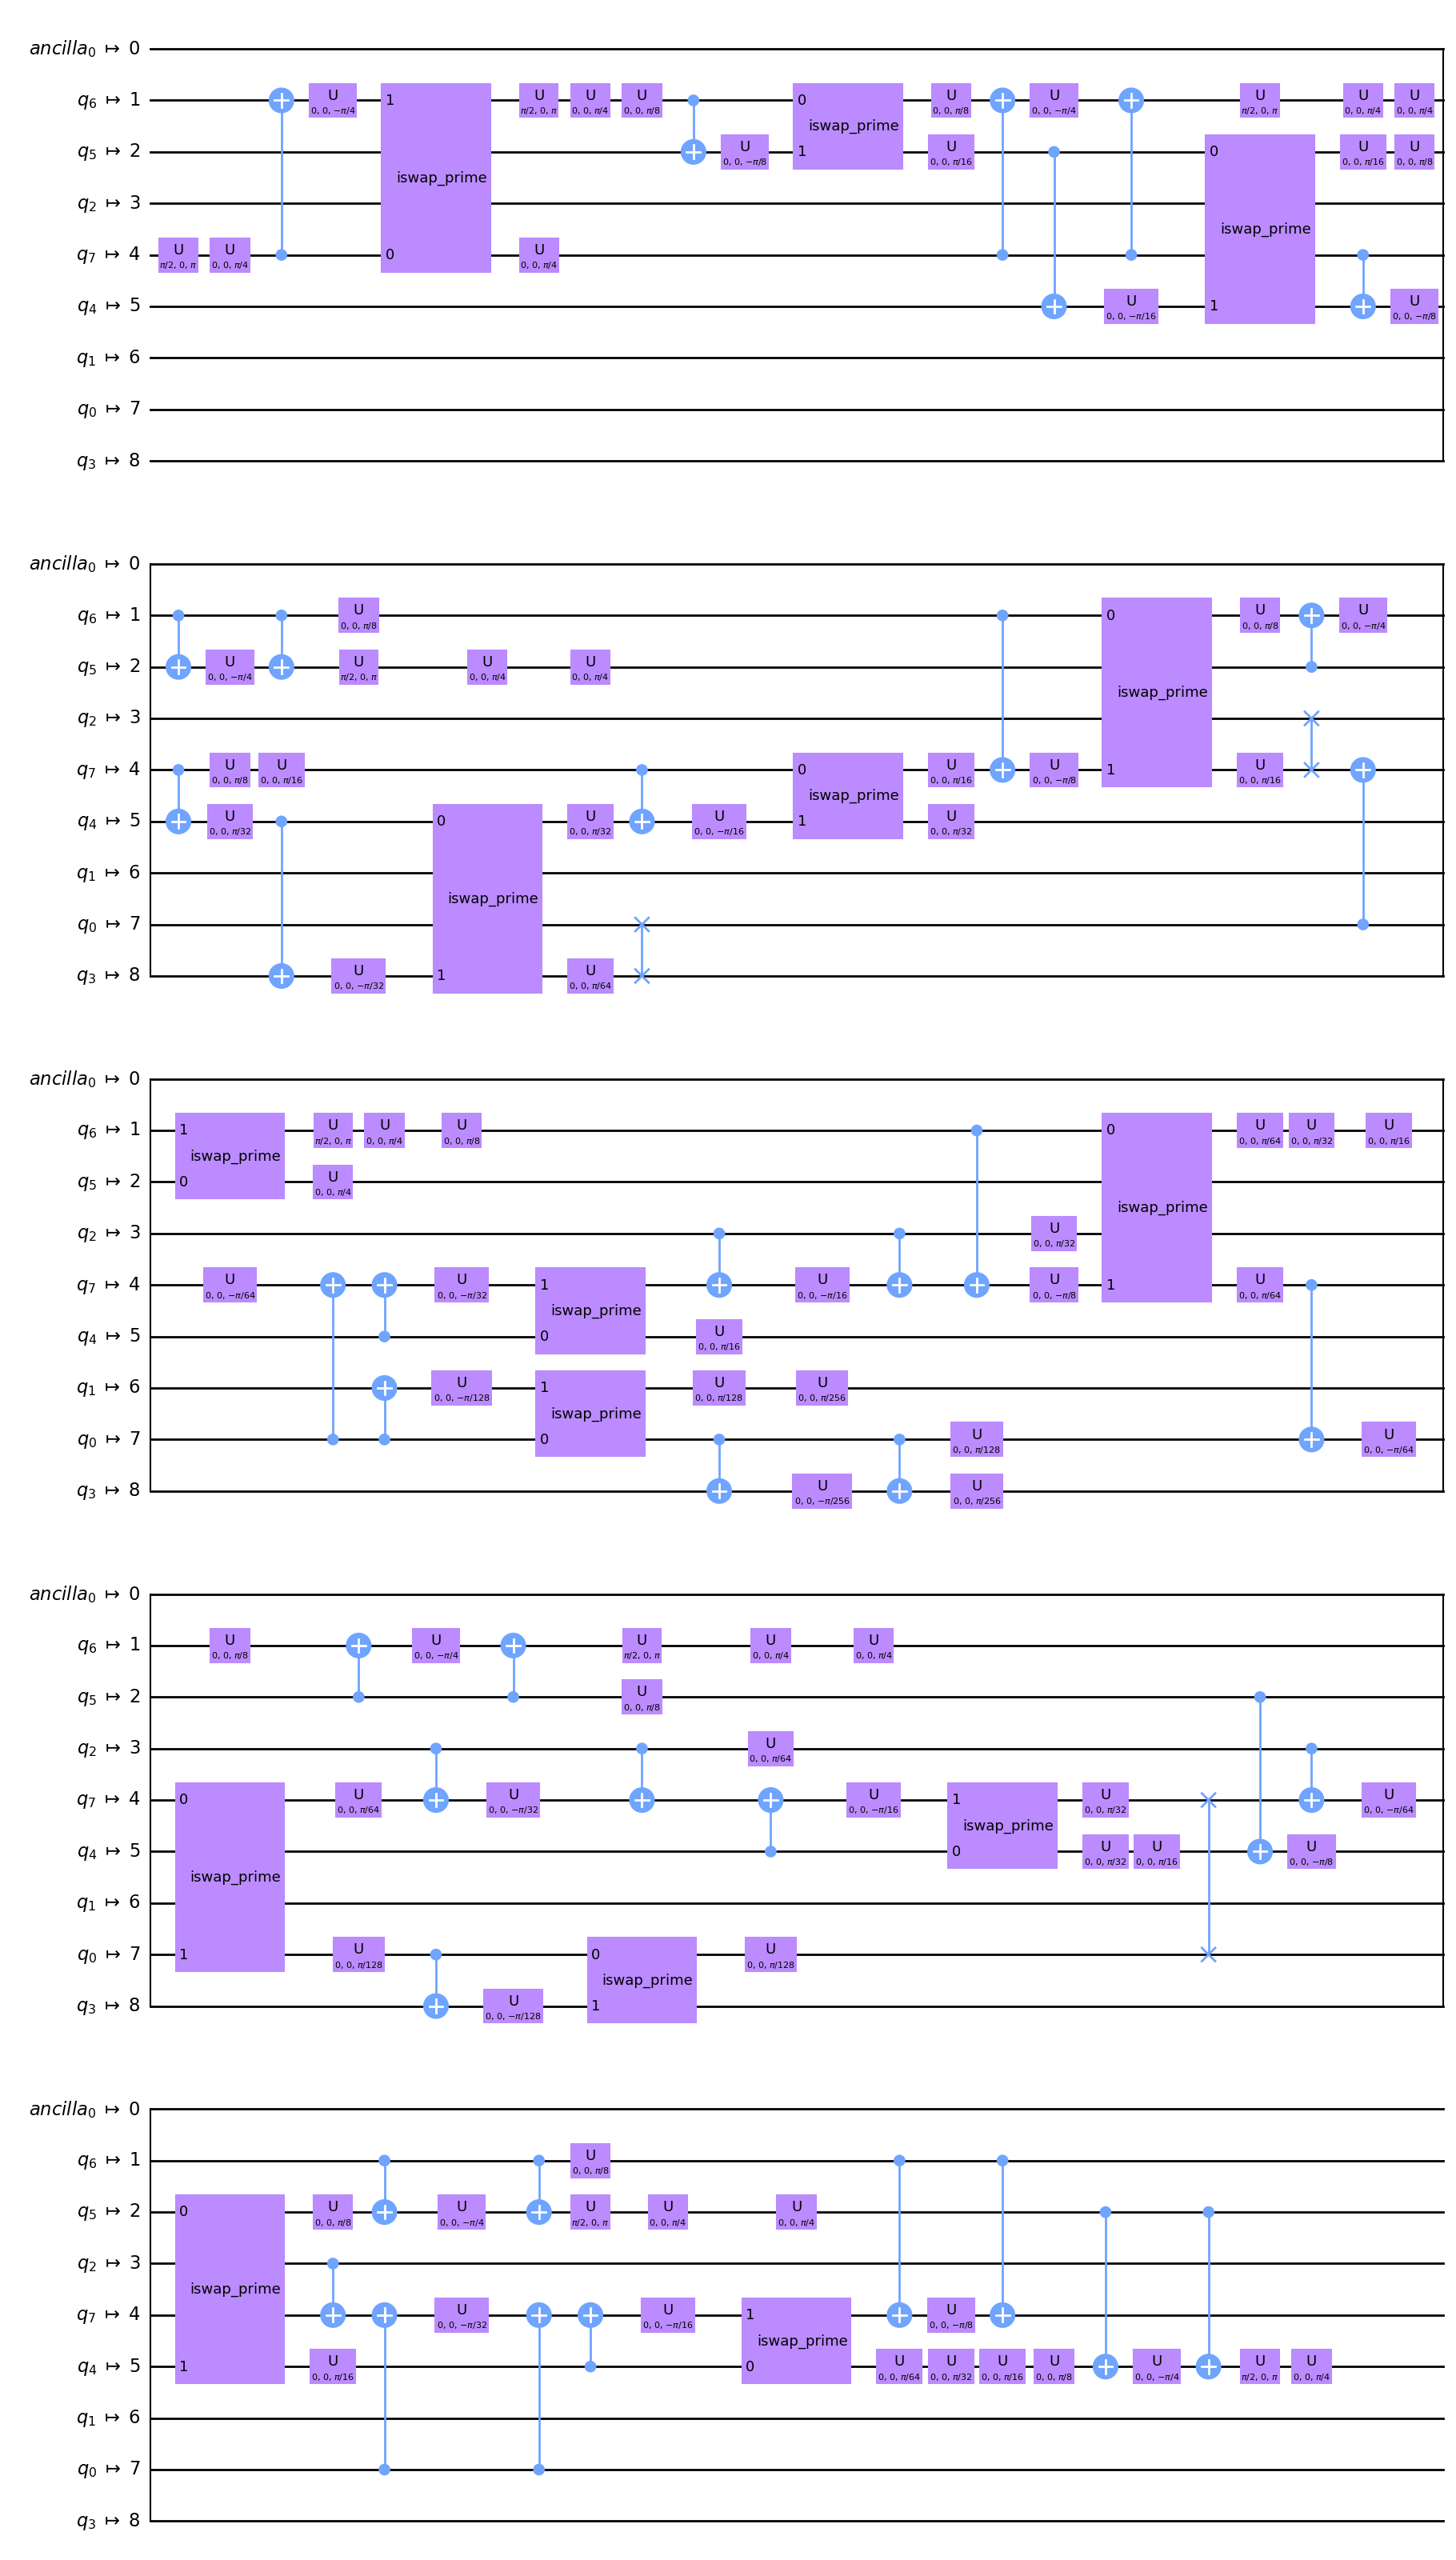

In [46]:
coupling_map = CouplingMap.from_grid(3, 3)
pm = SabreCNSV2(coupling_map, logger=transpile_benchy_logger)
# build a QFT circuit
transp = pm.run(qc)
from transpile_benchy.metrics import DepthMetric

print(DepthMetric.calculate(transp))
transp.draw("mpl")